## Check GPU

* Google Colab offered free GPUs not all compatible with mixed precision training.

* Tesla T4 is only compatible for mixed precision training. Or our own GPU with 7.0+

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cbe568d2-e5f0-d554-6fc6-6bfe634c1619)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-18 18:57:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-18 18:57:05 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions
from helper_functions import *

## Use TensorFlow Datasets (TFDS) download data

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [6]:
# Load in the data (takes 5-6 minutes in Google colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets return in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteWSMQPU/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteWSMQPU/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Data Sets


* Class names
* shape of input data (image tensors)
* The datatype of our input data
* What the labels look like (eg. are they one-hot encoded or label encoded)
* DO the labels match up with the class names

In [8]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
# Get the class names
class_names = ds_info.features["label"].names
class_names [:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [15]:
# Take one sample of the train data
train_one_smaple = train_data.take(1) # samples are in format (image_tensor, label)

In [16]:
# What does one sample of our training data look like?
train_one_smaple

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [17]:
# Output info about our training sample
for image, label in train_one_smaple:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (489, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 90
  Class name (str form): spaghetti_bolognese
  


In [18]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(489, 512, 3), dtype=uint8, numpy=
array([[[ 83,  71,  45],
        [ 81,  69,  43],
        [ 80,  68,  44],
        ...,
        [186, 183, 142],
        [188, 185, 144],
        [185, 182, 141]],

       [[ 86,  74,  48],
        [ 83,  71,  45],
        [ 82,  70,  46],
        ...,
        [180, 177, 136],
        [179, 176, 135],
        [182, 179, 138]],

       [[ 88,  76,  52],
        [ 87,  75,  51],
        [ 85,  73,  49],
        ...,
        [188, 185, 144],
        [186, 183, 142],
        [187, 184, 143]],

       ...,

       [[162, 163, 168],
        [164, 165, 170],
        [171, 170, 176],
        ...,
        [ 75,  74,  56],
        [ 67,  66,  48],
        [ 64,  63,  45]],

       [[168, 169, 174],
        [175, 176, 181],
        [167, 166, 172],
        ...,
        [ 79,  78,  60],
        [ 74,  73,  55],
        [ 79,  78,  60]],

       [[182, 183, 188],
        [178, 179, 184],
        [163, 164, 169],
        ...,
        [ 75,  74,  5

In [19]:
# What are the min and max values of our image tensor
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from Tensorflow image

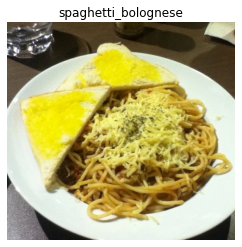

In [22]:
# Plot an image tensor
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (batched, normalized, etc).

However, not all data (include from TensorFlow Datasets)come like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data. 

What we know about our data:
* IN `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (0~255)

What we know models like:
* Data in `float32` dtype (or mixed precision `float16`) 
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better.

Few things we can tackle with a preprocessing function

Since we are going to use EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (architectures have rescaling built-in).

This means our functions need to:
1. Reshape our images to all same size
2. Convert the dtype of our image tensors from `unit8` to `float32`


In [23]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Conver image datatype from `uint8` -> `float32` and 
  reshapes image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [31]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]

In [33]:
preprocess_img(image, label)[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 83.108574,  71.108574,  45.108578],
        [ 82.11161 ,  70.11161 ,  46.11161 ],
        [ 84.873245,  72.873245,  49.30182 ],
        ...,
        [191.5464  , 188.5464  , 147.5464  ],
        [184.01991 , 181.01991 , 140.01991 ],
        [182.87247 , 179.87247 , 138.87247 ]],

       [[ 87.08051 ,  75.08051 ,  51.080517],
        [ 84.33609 ,  72.33609 ,  48.336098],
        [ 83.439735,  70.796875,  47.439735],
        ...,
        [198.13402 , 195.13402 , 154.13402 ],
        [194.08138 , 191.08138 , 150.08138 ],
        [193.38318 , 190.38318 , 149.38318 ]],

       [[ 85.02854 ,  70.02854 ,  49.028538],
        [ 80.481346,  65.481346,  44.481342],
        [ 84.41949 ,  69.41949 ,  48.419487],
        ...,
        [183.79121 , 179.79121 , 141.79121 ],
        [199.39262 , 195.39262 , 157.39262 ],
        [183.1326  , 179.1326  , 141.1326  ]],

       ...,

       [[169.07019 , 168.07019 , 174.07019 ],
        [165.

## Batch & prepare our datasets (To run fast)

In [35]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [38]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modeling callbacks

Create a couple of callbacks to help training models:
* TensorBoard callbacks to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction.

In [39]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved 

## Setup mixed precision training

Mixed precision utilizes a combination of float32 and float16 to speed up model performance

In [41]:
# Trun on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # Set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [42]:
!nvidia-smi

Fri Mar 18 20:25:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    270MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [43]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [44]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape=(224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you have to re-scale
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # Make sure layers which should be in inference model only
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [66]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [67]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype polices (are we using mixed precision?)

In [68]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [69]:
# 
for layer in model.layers[1].layers:
  print(layer.name, layer.dtype, layer.dtype_policy)

input_1 float32 <Policy "float32">
rescaling float32 <Policy "mixed_float16">
normalization float32 <Policy "mixed_float16">
stem_conv_pad float32 <Policy "mixed_float16">
stem_conv float32 <Policy "mixed_float16">
stem_bn float32 <Policy "mixed_float16">
stem_activation float32 <Policy "mixed_float16">
block1a_dwconv float32 <Policy "mixed_float16">
block1a_bn float32 <Policy "mixed_float16">
block1a_activation float32 <Policy "mixed_float16">
block1a_se_squeeze float32 <Policy "mixed_float16">
block1a_se_reshape float32 <Policy "mixed_float16">
block1a_se_reduce float32 <Policy "mixed_float16">
block1a_se_expand float32 <Policy "mixed_float16">
block1a_se_excite float32 <Policy "mixed_float16">
block1a_project_conv float32 <Policy "mixed_float16">
block1a_project_bn float32 <Policy "mixed_float16">
block2a_expand_conv float32 <Policy "mixed_float16">
block2a_expand_bn float32 <Policy "mixed_float16">
block2a_expand_activation float32 <Policy "mixed_float16">
block2a_dwconv_pad float3

## Fit the feature extraction model

In [70]:
history_101_food_classes_feature_extraction = model.fit(train_data,
          epochs=3,
          steps_per_epoch = len(train_data),
          validation_data=test_data,
          validation_steps=int(0.15*len(test_data)),
          callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                 experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                     model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220318-210430
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8203 - accuracy: 0.5570WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 181s 69ms/step - loss: 1.8203 - accuracy: 0.5570 - val_loss: 1.2251 - val_accuracy: 0.6801
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2940 - accuracy: 0.6659WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 160s 67ms/step - loss: 1.2940 - accuracy: 0.6659 - val_loss: 1.1376 - val_accuracy: 0.6941
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1436 - accuracy: 0.7019WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 159s 67ms/step - loss: 1.1436 - accuracy: 0.7019 - val_loss: 1.0874 - val_accuracy: 0.7076


In [71]:
# Evaluate on whole test dataset
resutls_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 48s 61ms/step - loss: 1.0891 - accuracy: 0.7056


[1.089129090309143, 0.7055841684341431]

## Fine-tuning

In [85]:
# Unfreeze all layers in the model
base_model.trainable = True

# Refreeze every layer except for the last  5
for layer in base_model.layers[:-5]:
  layer.trainable = False


# Recompile with lower learning rate
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

# Fine-tune for 3 more epochs
fine_tune_epochs = 6
history_all_classes_all_data_fine_tune = model.fit(train_data,
                                                   steps_per_epoch = len(train_data),
                                                   epochs=fine_tune_epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   initial_epoch=history_101_food_classes_feature_extraction.epoch[-1])


input_layer True
efficientnetb0 True
global_average_pooling2d True
dense True
softmax_float32 True
Epoch 3/6
2368/2368 [==============================] - 170s 68ms/step - loss: 0.9581 - accuracy: 0.7465 - val_loss: 0.9892 - val_accuracy: 0.7296
Epoch 4/6
2368/2368 [==============================] - 162s 67ms/step - loss: 0.8286 - accuracy: 0.7814 - val_loss: 0.9744 - val_accuracy: 0.7285
Epoch 5/6
2368/2368 [==============================] - 162s 68ms/step - loss: 0.7365 - accuracy: 0.8064 - val_loss: 0.9517 - val_accuracy: 0.7407
Epoch 6/6
2368/2368 [==============================] - 162s 68ms/step - loss: 0.6602 - accuracy: 0.8266 - val_loss: 0.9542 - val_accuracy: 0.7413


In [86]:
# Evaluate fine tune model
resutls_fine_tune_model = model.evaluate(test_data)
resutls_fine_tune_model

790/790 [==============================] - 47s 60ms/step - loss: 0.9542 - accuracy: 0.7407


[0.9542391896247864, 0.7407128810882568]

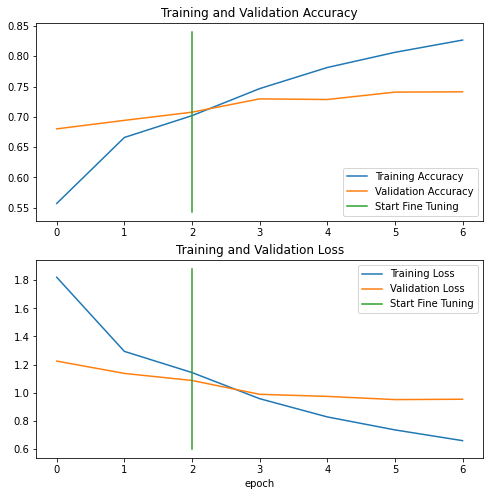

In [87]:
compare_historys(original_history=history_101_food_classes_feature_extraction,
                 new_history=history_all_classes_all_data_fine_tune,
                 initial_epochs=3)

In [81]:
history_all_classes_all_data_fine_tune.history

{}